In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
import networkx as nx

In [39]:
df = pd.read_csv('stats.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['item_description'] == 'Botella_750ml']
columns_drop = ['business', 'category', 'document', 'document_ID', 'client_name','total_sale_price', 'delivery_price',
       'gross_profit', 'total_taxes', 'total_tax_retention', 'current_balance',
       'amount_paid', 'payment_dates', 'gross_profit_percentage', 'address', 'item_ID', 'year_extracted', 'month_extracted','packaging','packaging','total_cost','item_description',
       'day_extracted']
df = df.drop(columns=columns_drop)
df['date'] = pd.to_datetime(df['date'])
df["client_ID"] = df["client_ID"].astype(int)
#df = df.groupby(['first_day_of_month']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'}).reset_index()
df.set_index('date', inplace=True)
df.head()

,unit_cost,sold_quantity,unit_price,client_ID
date,,,,
2020-01-04,9.54,1.0,15.8,1141
2020-01-08,9.54,10.0,15.9,188
2020-01-21,9.54,5.0,15.9,188
2020-01-24,9.54,6.0,15.9,1664
2020-02-11,9.54,1.0,21.5,1433


In [40]:
#train = df.loc[:'2023-01-01']
#test = df.loc['2023-02-01':]

In [41]:
drop = ['unit_cost','unit_price','client_ID']
df_model = df.drop(columns=drop)


In [42]:
def window_slide_method(df, windows_size = 7):
    
    df_np = df.to_numpy()
    X = []
    yhat = []
    for i in range(len(df_np)-windows_size):
        row = [[a] for a in df_np[i:i+windows_size]]
        X.append(row)
        label = df_np[i+windows_size]
        yhat.append(label)
    return np.array(X), np.array(yhat)

X, y = window_slide_method(df_model)
X.shape, y.shape

((1262, 7, 1, 1), (1262, 1))

In [43]:
X_train, y_train = X[:850], y[:850]
X_val, y_val = X[850:1000], y[850:1000]
X_test, y_test = X[1000:], y[1000:]

In [44]:
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
checkpoint = ModelCheckpoint('model1/model_best.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [46]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[checkpoint])
model1 = load_model('model1/model_best.keras')

Epoch 1/20


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 63.3238 - root_mean_squared_error: 7.8690 - val_loss: 158.2131 - val_root_mean_squared_error: 12.9349
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87.9421 - root_mean_squared_error: 9.3321 - val_loss: 154.8713 - val_root_mean_squared_error: 12.8011
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.8214 - root_mean_squared_error: 8.6233 - val_loss: 151.6333 - val_root_mean_squared_error: 12.6695
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.0493 - root_mean_squared_error: 8.2132 - val_loss: 148.5007 - val_root_mean_squared_error: 12.5401
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 56.1206 - root_mean_squared_error: 7.2051 - val_loss: 145.7992 - val_root_mean_squared_error: 12.4265
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.9516 - root_mean_squared_error: 7.4487 - val_loss: 143.7059 - val_root_mean_squared_error: 12.3364
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [47]:
train_prediction = model1.predict(X_test).flatten()
y_test_flat = np.ravel(y_test)
train_result = pd.DataFrame(data={'train': train_prediction, 'Actual': y_test_flat})
train_result

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,train,Actual
0,5.166883,2.0
1,4.982063,1.0
2,4.840294,3.0
3,3.962339,3.0
4,3.496530,2.0
...,...,...
257,2.577141,1.0
258,2.615037,15.0
259,4.285774,1.0
260,4.110762,2.0


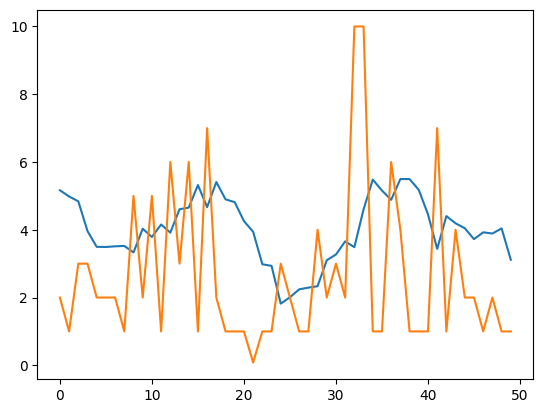

In [48]:
plt.plot(train_result['train'][:50])
plt.plot(train_result['Actual'][:50])

In [53]:
G = nx.Graph()
drop = ['unit_cost','unit_price']
df_model_2 = df.drop(columns=drop)
df_model_2

,sold_quantity,client_ID
date,,
2020-01-04,1.0,1141
2020-01-08,10.0,188
2020-01-21,5.0,188
2020-01-24,6.0,1664
2020-02-11,1.0,1433
...,...,...
2024-01-05,1.0,670
2024-01-05,15.0,375
2024-01-10,1.0,670


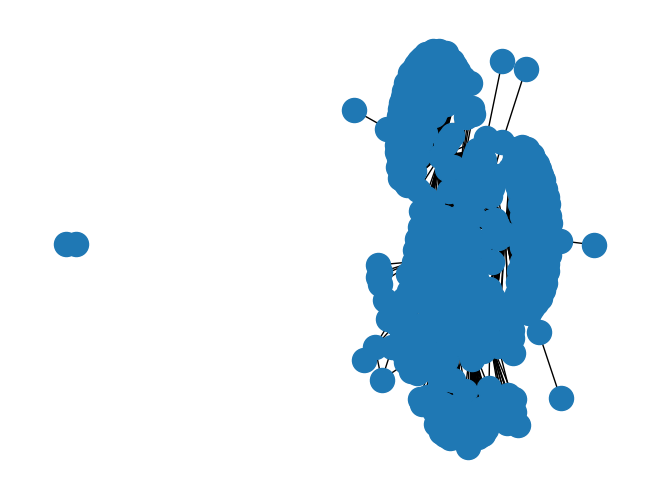

In [56]:
for index, row in df_model_2.iterrows():
    client_id = row['client_ID']
    qty_buy = row['sold_quantity']
    purchase_date = index

    if not G.has_node(client_id):
        G.add_node(client_id, type='client')

    if not G.has_node(qty_buy):
        G.add_node(qty_buy, type='item')

    G.add_edge(client_id, qty_buy, purchase_date=purchase_date)
    
nx.draw(G)